In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import os
import torchvision
from torchvision import transforms
from PIL import Image, UnidentifiedImageError
from torchvision import datasets
from tqdm import tqdm
from torch.amp import autocast, GradScaler
from torchvision.transforms import ToTensor
from google.colab import drive
from timeit import default_timer as timer
import random
import functools

# Disable the DecompressionBombWarning by setting no limit on pixel count
Image.MAX_IMAGE_PIXELS = None


In [2]:

drive.mount('/content/drive')

Mounted at /content/drive


In [23]:

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(4)

In [4]:

zip_file_path_content = '/content/drive/MyDrive/GAN/Content.zip'
zip_file_path_style = '/content/drive/MyDrive/GAN/uki.zip'


extract_dir_content = '/content/content_data'
extract_dir_style = '/content/style_data'


os.makedirs(extract_dir_content, exist_ok=True)
os.makedirs(extract_dir_style, exist_ok=True)


with zipfile.ZipFile(zip_file_path_content, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_content)
with zipfile.ZipFile(zip_file_path_style, 'r') as zip_ref:
    zip_ref.extractall(extract_dir_style)

os.listdir(extract_dir_style)

['ukiyoe', '__MACOSX']

In [5]:

num_images = len(os.listdir('/content/style_data/ukiyoe'))
print(f"Number of images: {num_images}")

Number of images: 3966


In [24]:


class CycleGANStyleTransferDataset(Dataset):
    def __init__(self, content_dir, style_dir, transform=None):
        """
        Args:
            content_dir (str): Directory path for content images (Domain A).
            style_dir (str): Directory path for style images (Domain B).
            transform (callable, optional): A function/transform to apply to both domains.
        """
        # Filter and load only valid image files (ignoring files like .DS_Store)
        self.content_images = sorted([f for f in os.listdir(content_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
        self.style_images = sorted([f for f in os.listdir(style_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif'))])
        self.content_dir = content_dir
        self.style_dir = style_dir
        self.transform = transform

    def __len__(self):
        return min(len(self.content_images), len(self.style_images))

    def __getitem__(self, idx):
      while True:
          content_image_path = os.path.join(self.content_dir, self.content_images[idx % len(self.content_images)])
          try:
              content_image = Image.open(content_image_path).convert('RGB')
              break
          except UnidentifiedImageError:
              print(f"Error: Cannot open content image {content_image_path}. Skipping.")
              idx += 1
      while True:
          style_image_path = os.path.join(self.style_dir, self.style_images[idx % len(self.style_images)])
          try:
              style_image = Image.open(style_image_path).convert('RGB')
              break
          except UnidentifiedImageError:
              print(f"Error: Cannot open style image {style_image_path}. Skipping.")
              idx += 1
      if self.transform:
          content_image = self.transform(content_image)
          style_image = self.transform(style_image)

      return content_image, style_image


In [25]:
# Data transformation

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


content_dir = '/content/content_data/Content/photo_jpg'
style_dir = '/content/style_data/ukiyoe'


cyclegan_dataset = CycleGANStyleTransferDataset(content_dir=content_dir, style_dir=style_dir, transform=transform)


Total number of batches: 992


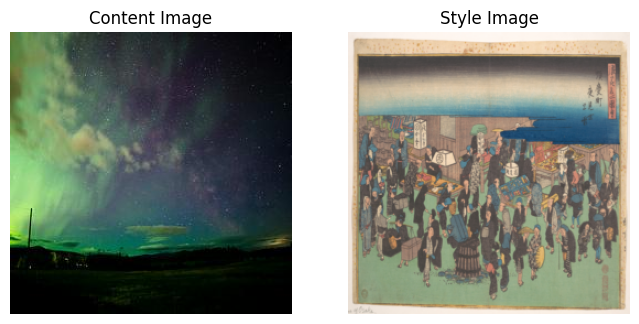

In [26]:
dataloader = DataLoader(cyclegan_dataset, batch_size=4, shuffle=True)
total_batches = len(dataloader)
print(f"Total number of batches: {total_batches}")

content_images, style_images = next(iter(dataloader))

# Display the content and style images at the 0th index of the first batch
def show_image(image_tensor, title):
    image = image_tensor.permute(1, 2, 0).numpy()
    image = (image * 0.5) + 0.5
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')


plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
show_image(content_images[0], title="Content Image")
plt.subplot(1, 2, 2)
show_image(style_images[0], title="Style Image")
plt.show()



In [9]:


class ResnetBlock(nn.Module):
    def __init__(self, dim, norm_layer):
        super(ResnetBlock, self).__init__()
        self.conv_block = self.build_conv_block(dim, norm_layer)

    def build_conv_block(self, dim, norm_layer):
        conv_block = []
        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       norm_layer(dim),
                       nn.ReLU(True)]

        conv_block += [nn.ReflectionPad2d(1),
                       nn.Conv2d(dim, dim, kernel_size=3, padding=0, bias=True),
                       norm_layer(dim)]

        return nn.Sequential(*conv_block)

    def forward(self, x):
        return x + self.conv_block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, input_nc, output_nc, ngf=64, norm_layer=nn.InstanceNorm2d, use_dropout=False, n_blocks=9, padding_type='reflect'):
        assert(n_blocks >= 0)
        super(ResnetGenerator, self).__init__()
        if type(norm_layer) == functools.partial:
            use_bias = norm_layer.func == nn.InstanceNorm2d
        else:
            use_bias = norm_layer == nn.InstanceNorm2d

        model = [nn.ReflectionPad2d(3),
                 nn.Conv2d(input_nc, ngf, kernel_size=7, padding=0, bias=use_bias),
                 norm_layer(ngf),
                 nn.ReLU(True)]

        # Downsampling
        n_downsampling = 2
        for i in range(n_downsampling):
            mult = 2 ** i
            model += [nn.Conv2d(ngf * mult, ngf * mult * 2, kernel_size=3, stride=2, padding=1, bias=use_bias),
                      norm_layer(ngf * mult * 2),
                      nn.ReLU(True)]

        # ResNet
        mult = 2 ** n_downsampling
        for i in range(n_blocks):
            model += [ResnetBlock(ngf * mult, norm_layer=norm_layer)]

        # Upsampling
        for i in range(n_downsampling):
            mult = 2 ** (n_downsampling - i)
            model += [nn.ConvTranspose2d(ngf * mult, ngf * mult // 2,
                                         kernel_size=3, stride=2,
                                         padding=1, output_padding=1, bias=use_bias),
                      norm_layer(ngf * mult // 2),
                      nn.ReLU(True)]

        model += [nn.ReflectionPad2d(3)]
        model += [nn.Conv2d(ngf, output_nc, kernel_size=7, padding=0)]
        model += [nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, input):
        return self.model(input)


In [10]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [11]:
# Discriminator Architecture
# PatchGAN Discriminator
class NLayerDiscriminator(nn.Module):
    def __init__(self, input_nc, ndf=64, n_layers=3):
        """Construct a PatchGAN discriminator"""
        super(NLayerDiscriminator, self).__init__()
        kw = 4
        padw = 1
        sequence = [
            nn.Conv2d(input_nc, ndf, kernel_size=kw, stride=2, padding=padw),
            nn.LeakyReLU(0.2, True)
        ]

        nf_mult = 1
        nf_mult_prev = 1
        for n in range(1, n_layers):
            nf_mult_prev = nf_mult
            nf_mult = min(2 ** n, 8)
            sequence += [
                nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=2, padding=padw, bias=False),
                nn.InstanceNorm2d(ndf * nf_mult),
                nn.LeakyReLU(0.2, True)
            ]

        nf_mult_prev = nf_mult
        nf_mult = min(2 ** n_layers, 8)
        sequence += [
            nn.Conv2d(ndf * nf_mult_prev, ndf * nf_mult, kernel_size=kw, stride=1, padding=padw, bias=False),
            nn.InstanceNorm2d(ndf * nf_mult),
            nn.LeakyReLU(0.2, True)
        ]


        sequence += [nn.Conv2d(ndf * nf_mult, 1, kernel_size=kw, stride=1, padding=padw)]

        self.model = nn.Sequential(*sequence)

    def forward(self, input):
        """Forward pass"""
        return self.model(input)


In [12]:
input_nc=3
output_nc=3
# Initialize the generators
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
G = ResnetGenerator(input_nc=input_nc, output_nc=output_nc).to(device)  # Generator A -> B (Photos to Ukiyo-e)
F = ResnetGenerator(input_nc=output_nc, output_nc=input_nc).to(device)  # Generator B -> A (Ukiyo-e to Photos)

# Initialize the discriminators
D_A = NLayerDiscriminator(input_nc=input_nc).to(device)  # Discriminator for Domain A (Photos)
D_B = NLayerDiscriminator(input_nc=output_nc).to(device)  # Discriminator for Domain B (Ukiyo-e)


# Defining optimizer
optimizer_G = optim.Adam(G.parameters(), lr=0.00025, betas=(0.5, 0.999))
optimizer_F = optim.Adam(F.parameters(), lr=0.00025, betas=(0.5, 0.999))
optimizer_D_A = optim.Adam(D_A.parameters(), lr=0.00025, betas=(0.5, 0.999))
optimizer_D_B = optim.Adam(D_B.parameters(), lr=0.00025, betas=(0.5, 0.999))

In [13]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
# Apply the weights initialization function to each model
G.apply(weights_init_normal)
F.apply(weights_init_normal)
D_A.apply(weights_init_normal)
D_B.apply(weights_init_normal)

NLayerDiscriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [14]:

# Adversarial loss
adversarial_loss = nn.MSELoss()

# Cycle consistency
cycle_loss = nn.L1Loss()

# Identity loss
identity_loss = nn.L1Loss()

# Loss weights
lambda_cycle = 10.0
lambda_identity = 5.0


In [ ]:

batch_size = 4
save_dir = "/content/drive/MyDrive/GAN/weights"

if not os.path.exists(save_dir):
    os.makedirs(save_dir)


num_epochs = 15
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


scaler = GradScaler(device='cuda')


def denormalize(tensor):
    tensor = tensor.detach() * 0.5 + 0.5
    return tensor.cpu().float().numpy()


def plot_images(real_A, fake_B, real_B, fake_A, epoch):
    fig, axs = plt.subplots(1, 4, figsize=(15, 5))
    axs[0].imshow(np.transpose(denormalize(real_A), (1, 2, 0)))
    axs[0].set_title("Real A")
    axs[1].imshow(np.transpose(denormalize(fake_B), (1, 2, 0)))
    axs[1].set_title("Fake B (A -> B)")
    axs[2].imshow(np.transpose(denormalize(real_B), (1, 2, 0)))
    axs[2].set_title("Real B")
    axs[3].imshow(np.transpose(denormalize(fake_A), (1, 2, 0)))
    axs[3].set_title("Fake A (B -> A)")

    for ax in axs:
        ax.axis("off")

    plt.suptitle(f"Epoch {epoch}")
    plt.show()

G.load_state_dict(torch.load('/content/drive/MyDrive/GAN/weights/G_epoch_522.pth'))
F.load_state_dict(torch.load('/content/drive/MyDrive/GAN/weights/F_epoch_522.pth'))
D_A.load_state_dict(torch.load('/content/drive/MyDrive/GAN/weights/D_A_epoch_522.pth'))
D_B.load_state_dict(torch.load('/content/drive/MyDrive/GAN/weights/D_B_epoch_522.pth'))

# Training Loop
for epoch in range(num_epochs):
    with tqdm(total=len(dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}", leave=True) as pbar:
        total_loss_G = 0
        total_loss_D_A = 0
        total_loss_D_B = 0

        for i, (real_A, real_B) in enumerate(dataloader):
            real_A = real_A.to(device)
            real_B = real_B.to(device)
            optimizer_G.zero_grad()

            with autocast(device_type='cuda'):
                fake_B = G(real_A)  # A -> B
                fake_A = F(real_B)  # B -> A

                recov_A = F(fake_B)  # B -> A -> B
                recov_B = G(fake_A)  # A -> B -> A

                # Generating labels
                valid = torch.ones_like(D_B(fake_B), requires_grad=False).to(device)
                fake = torch.zeros_like(D_B(fake_B), requires_grad=False).to(device)

                loss_GAN_G = adversarial_loss(D_B(fake_B), valid)
                loss_GAN_F = adversarial_loss(D_A(fake_A), valid)

                loss_cycle_A = cycle_loss(recov_A, real_A) * lambda_cycle
                loss_cycle_B = cycle_loss(recov_B, real_B) * lambda_cycle

                loss_identity_A = identity_loss(F(real_A), real_A) * lambda_identity
                loss_identity_B = identity_loss(G(real_B), real_B) * lambda_identity

                loss_G = loss_GAN_G + loss_GAN_F + loss_cycle_A + loss_cycle_B + loss_identity_A + loss_identity_B

            # Backward pass and update generator weights
            scaler.scale(loss_G).backward()
            scaler.step(optimizer_G)
            scaler.update()

            #  Train Discriminators D_A and D_B
            optimizer_D_A.zero_grad()
            optimizer_D_B.zero_grad()

            with autocast(device_type='cuda'):
                loss_real_A = adversarial_loss(D_A(real_A), valid)
                loss_fake_A = adversarial_loss(D_A(fake_A.detach()), fake)
                loss_D_A = (loss_real_A + loss_fake_A) * 0.5

                loss_real_B = adversarial_loss(D_B(real_B), valid)
                loss_fake_B = adversarial_loss(D_B(fake_B.detach()), fake)
                loss_D_B = (loss_real_B + loss_fake_B) * 0.5

            # Backward pass and update discriminator weights
            scaler.scale(loss_D_A).backward()
            scaler.scale(loss_D_B).backward()
            scaler.step(optimizer_D_A)
            scaler.step(optimizer_D_B)
            scaler.update()

            total_loss_G += loss_G.item()
            total_loss_D_A += loss_D_A.item()
            total_loss_D_B += loss_D_B.item()

            pbar.set_postfix({
                'Loss_G': total_loss_G / (i + 1),
                'Loss_D_A': total_loss_D_A / (i + 1),
                'Loss_D_B': total_loss_D_B / (i + 1)
            })
            pbar.update(1)

    avg_loss_G = total_loss_G / len(dataloader)
    avg_loss_D_A = total_loss_D_A / len(dataloader)
    avg_loss_D_B = total_loss_D_B / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}] Avg Loss_G: {avg_loss_G:.4f}, Avg Loss_D_A: {avg_loss_D_A:.4f}, Avg Loss_D_B: {avg_loss_D_B:.4f}")
    plot_images(real_A[0], fake_B[0], real_B[0], fake_A[0], epoch + 1)

    # Save model parameters
    torch.save(G.state_dict(), os.path.join(save_dir, f'G_epoch_{epoch+52}.pth'))
    torch.save(F.state_dict(), os.path.join(save_dir, f'F_epoch_{epoch+52}.pth'))
    torch.save(D_A.state_dict(), os.path.join(save_dir, f'D_A_epoch_{epoch+52}.pth'))
    torch.save(D_B.state_dict(), os.path.join(save_dir, f'D_B_epoch_{epoch+52}.pth'))


<ipython-input-15-03ca6aba2510>:38: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('/content/drive/MyDrive/GAN/weights/G_epoch_522.pth'))
<ipytho

KeyboardInterrupt: 

In [59]:

def denormalize(tensor):
    tensor = tensor.detach() * 0.5 + 0.5
    return tensor.cpu().float().numpy()

def plot_photo_to_ukiyoe(real_photo, fake_ukiyoe):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(np.transpose(denormalize(real_photo), (1, 2, 0)))
    axs[0].set_title("Real Photo")
    axs[0].axis("off")

    axs[1].imshow(np.transpose(denormalize(fake_ukiyoe), (1, 2, 0)))
    axs[1].set_title("Generated Ukiyoe")
    axs[1].axis("off")

    plt.show()


def visualize_after_training(generator_G, dataloader, device='cuda'):
    generator_G.eval()

    real_photos, _ = next(iter(dataloader))
    real_photos = real_photos.to(device)
    with torch.no_grad():
        fake_ukiyoe = generator_G(real_photos)

    for i in range(min(4, real_photos.size(0))):
        plot_photo_to_ukiyoe(real_photos[i], fake_ukiyoe[i])
    generator_G.train()


#set_seed(31)
G.load_state_dict(torch.load('/content/drive/MyDrive/GAN/weights/G_epoch_52.pth'))
visualize_after_training(G, dataloader, device=device)


Output hidden; open in https://colab.research.google.com to view.

<ipython-input-61-2b776fb3e441>:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G.load_state_dict(torch.load('/content/drive/MyDrive/GAN/weights/G_epoch_52.pth'))


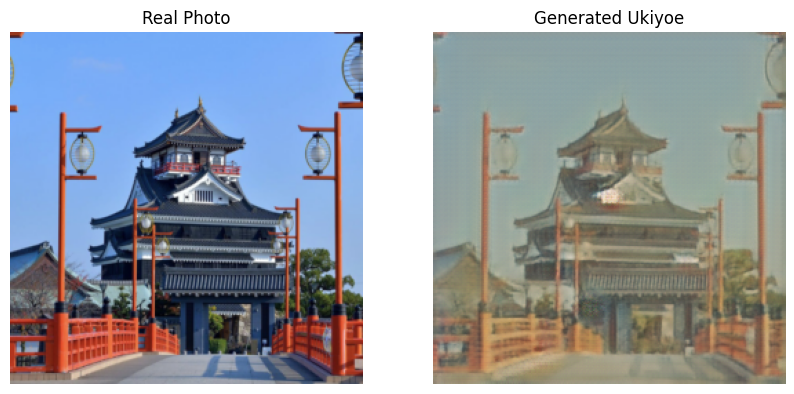

In [61]:
# Testing the Generator on some unseen data
def denormalize(tensor):
    tensor = tensor.detach() * 0.5 + 0.5
    return tensor.cpu().float().numpy()

def plot_photo_to_ukiyoe(real_photo, fake_ukiyoe):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(np.transpose(denormalize(real_photo), (1, 2, 0)))
    axs[0].set_title("Real Photo")
    axs[0].axis("off")
    axs[1].imshow(np.transpose(denormalize(fake_ukiyoe), (1, 2, 0)))
    axs[1].set_title("Generated Ukiyoe")
    axs[1].axis("off")

    plt.show()


def preprocess_image(image_path, device='cuda'):
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    image = Image.open(image_path).convert("RGB")
    image = transform(image).unsqueeze(0)
    return image.to(device)


def visualize_single_image(generator_G, image_path, device='cuda'):
    generator_G.eval()
    real_photo = preprocess_image(image_path, device)

    with torch.no_grad():
        fake_ukiyoe = generator_G(real_photo)

    plot_photo_to_ukiyoe(real_photo[0], fake_ukiyoe[0])
    generator_G.train()

G.load_state_dict(torch.load('/content/drive/MyDrive/GAN/weights/G_epoch_52.pth'))
image_path = '/content/test3.png'
visualize_single_image(G, image_path, device='cuda')
